## Наименование проекта

Анализ оттока клиентов банка "Метанпром"

## Цель проекта

В банке повысился отток, и с этим нужно что-то делать. Ранее было проведено исследование оттока, составлены дэшборды и выделены сегменты, но клиентская база поменялась, и текущие решения не работают. Необходимо выделить отточные сегменты и дать рекомендации по его снижению.

## План действий

1) Провести исследовательский анализ данных, определить все значимые признаки отточности (интервалы значений характеристик, которые связаны с повышенным оттоком, сравнить портреты типичных клиентов, которые склонны и не склонны уходить из банка и т.д)

2) Сформулировать и проверить статистические гипотезы. Проверить гипотезы о различии дохода и количества баллов скоринга между теми клиентами, которые ушли и теми, которые остались.

3) Объединяя признаки отточности, сформировать сегменты, отобрать из них лучшие и дать по ним рекомендации отделу маркетинга.

## Предобработка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math as mth
import scipy.stats as st
import numpy as np
import datetime as dt
import scipy.stats as stats
import seaborn as sns
from plotly import graph_objects as go

### Открыть файл с данными и изучить общую информацию

In [2]:
df = pd.read_csv('/datasets/bank_scrooge.csv')

In [3]:
df.head()

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1


Датасет содержит данные о клиентах банка «Метанпром». В нем 12 колонок, которые несут в себе следующую информацию:

1) USERID - идентификатор пользователя;

2) score - баллы кредитного скоринга;

3) city - город;

4) gender - пол;

5) age - возраст;

6) equity - количество баллов собственности;

7) balance - баланс на счёте;

8) products - количество продуктов;

9) credit_card - имеется ли кредитная карта;

10) last_activity - активный ли клиент (заходил в приложение в течение прошедших 30 дней);

11) EST_SALARY - заработная плата клиента;

12) churn - ушел клиент или нет.

### Исследовать соответствие типов

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


В датасете 9 колонок и 10000 строк.

Следующие столбцы хранят тип int: USERID, equity, products, credit_card, last_activity, churn.

Следующие столбцы хранят тип float: score, age, balance, EST_SALARY.

Следующие столбцы хранят тип object: city, gender.

### Переименовать колонки

Перепишем столбцы USERID и EST_SALARY в нижний змеиный регистр.

In [5]:
df = df.rename(columns={'USERID':'user_id','EST_SALARY':'est_salary'})

### Исследовать и заменить пропущенные значения

In [6]:
print('Количество пропусков:', df.isna().sum())

Количество пропусков: user_id             0
score               0
city                0
gender              0
age                26
equity              0
balance          2295
products            0
credit_card         0
last_activity       0
est_salary          0
churn               0
dtype: int64


Пропуски в датасете наблюдаются в двух столбцах - age (26) и balance (2295). Если 26 пропусков из 10000 это достаточно мало, то пропуски по столбцу balance составляют практически 1/4 от всей информации по столбцу.

Проверим, что уникальных городов точно 3.

In [7]:
print('Города в датасете:', df['city'].unique())

Города в датасете: ['Рыбинск' 'Ярославль' 'Ростов']


In [8]:
pd.set_option('display.max_rows', None)

Определим границы значений в столбцах с пропущенными значениями.

In [9]:
print('Минимальный возраст клиента:', df['age'].min())
print('Максимальный возраст клиента:', df['age'].max())

Минимальный возраст клиента: 18.0
Максимальный возраст клиента: 86.0


In [10]:
print('Минимальный баланс клиента:', df['balance'].min())
print('Максимальный баланс клиента:', df['balance'].max())

Минимальный баланс клиента: 0.0
Максимальный баланс клиента: 119113552.01


In [11]:
df_balance_nan = df.query('balance.isna()')
df_balance_nan.head(10)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
9,133130,906.0,Ярославль,Ж,67.0,0,NaN,1,0,1,238055.53,0
10,148929,927.0,Ростов,М,52.0,0,NaN,1,1,1,196820.07,0
11,172184,921.0,Ростов,М,41.0,0,NaN,1,1,1,217469.48,0
19,127034,922.0,Рыбинск,Ж,53.0,0,NaN,1,0,0,147094.82,0
21,177415,896.0,Рыбинск,Ж,47.0,0,NaN,1,0,0,225060.35,0
30,155730,946.0,Ярославль,Ж,47.0,0,NaN,2,1,1,660015.85,0
34,205226,944.0,Ярославль,М,35.0,0,NaN,2,1,1,239843.39,0
39,173175,924.0,Рыбинск,Ж,51.0,0,NaN,1,1,1,248844.47,0
43,228585,956.0,Ростов,М,41.0,0,NaN,1,1,0,115117.10,0


Проанализируем распределение баллов кредитного скоринга, возраста и заработной платы у клиентов, у коготорых пропущены значения по столбцу balance.

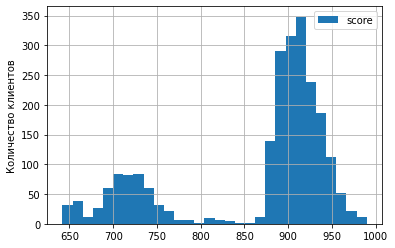

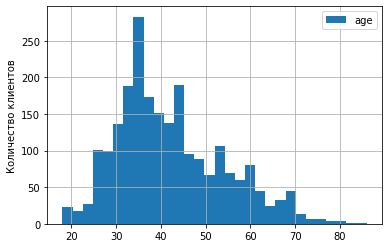

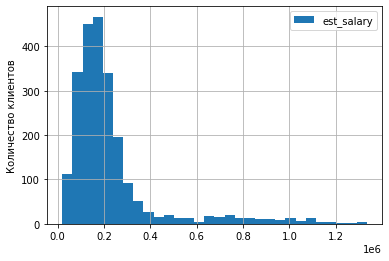

In [12]:
for column in ['score', 'age', 'est_salary']:
    df_balance_nan.plot(y=column, kind='hist', bins=30, grid=True)
    plt.ylabel('Количество клиентов')

Анализируя полученные гистограммы, можно сделать вывод, что зависимости пропущенных значений от баллов кредитного скоринга, возраста и заработной платы клиентов не наблюдается. Пропуски не зависят от переменных и не ведут к систематической ошибке, но увеличивают случайную ошибку. В данном случае нет возможности заполнить такое большое количество пропусков (почти 25%) от общих данных и, тем более, отбрасывать их также нет смысла. Оставим пропуски как есть.

### Исследовать дубликаты

In [13]:
print('Количество явных дубликатов:', df.duplicated().sum())

Количество явных дубликатов: 0


In [14]:
print('Количество неявных дубликатов:', df.duplicated(subset = ['user_id']).sum())

Количество неявных дубликатов: 73


In [36]:
df[df.duplicated(subset = ['user_id'], keep=False)].head(10)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
7,218868,825.0,Ярославль,Ж,38.0,4,458145.40,2,1,1,68085.48,0
58,164676,860.0,Ярославль,М,37.0,5,648594.03,2,1,1,213586.86,1
150,185748,850.0,Рыбинск,М,36.0,5,1203376.67,2,0,1,89401.82,1
161,197364,928.0,Рыбинск,Ж,53.0,6,1347183.86,2,0,1,168189.49,1
231,190253,823.0,Рыбинск,М,37.0,4,373348.39,2,0,1,131947.92,1
431,214031,856.0,Рыбинск,М,36.0,2,386426.67,4,1,1,72767.85,0
440,221197,663.0,Рыбинск,М,27.0,0,NaN,1,1,1,172573.13,0
690,152479,768.0,Рыбинск,Ж,42.0,0,126787.79,4,1,1,143233.23,1
790,170312,901.0,Ярославль,М,33.0,4,3276783.93,3,0,1,358700.96,1
869,210662,962.0,Ярославль,Ж,54.0,5,5069231.39,1,1,1,955144.85,1


Проверив дубликаты только по столбцу user_id, мы обнаружили, что их - 73 штуки. То есть в сумме в таблице находятся 146 повторяющихся записей. Просмотрим отдельно несколько user_id чтобы решить что делать с ними дальше.

In [16]:
df.loc[df['user_id'] == 190253]

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
231,190253,823.0,Рыбинск,М,37.0,4,373348.39,2,0,1,131947.92,1
1583,190253,726.0,Ярославль,М,49.0,0,NaN,1,1,1,177700.78,0


Данные не совпадают ни по одному столбцу, кроме user_id. Можно предположить, что банки из трех разных городов дают одинаковые id своим клиентам.

In [17]:
df.loc[df['user_id'] == 210662]

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
869,210662,962.0,Ярославль,Ж,54.0,5,5069231.39,1,1,1,955144.85,1
1837,210662,896.0,Рыбинск,Ж,37.0,0,NaN,2,0,0,90916.04,0


Аналогичная ситуация - нет совпадений. Значит эти двое людей - разные клиенты банка из разных городов.

Неявные строки-дубликаты решено не удалять.

### Исследовать аномалии

In [18]:
df.query('products == 0')

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
8957,147837,962.0,Рыбинск,Ж,79.0,3,NaN,0,0,0,25063.96,1


В данных есть один клиент, у которого количество банковских продуктов равно 0. Такого не может быть, потому что если у клиента есть счет, то у него имеется как минимум один продукт.

Изменим значение этой аномалии на 1.

In [19]:
df.at[8957, 'products'] = 1

### Кодирование данных

Чтобы в дальнейшем провести анализ корреляции, произведем one-hot кодирование переменных по столбцам gender и city.

In [20]:
df_coded = pd.get_dummies(df, columns=['gender', 'city'])
df_coded = df_coded.drop(columns=['user_id'])
df_coded.head(5)

,score,age,equity,balance,products,credit_card,last_activity,est_salary,churn,gender_Ж,gender_М,city_Ростов,city_Рыбинск,city_Ярославль
0,850.0,25.0,1,59214.82,2,0,1,75719.14,1,1,0,0,1,0
1,861.0,37.0,5,850594.33,3,1,0,86621.77,0,1,0,0,1,0
2,892.0,30.0,0,NaN,1,1,1,107683.34,0,1,0,0,1,0
3,866.0,51.0,5,1524746.26,2,0,1,174423.53,1,1,0,0,0,1
4,730.0,34.0,5,174.00,1,1,0,67353.16,1,0,1,0,0,1


**Вывод по пункту**

На этапе предобработки данных мы переименовали два столбца для облегчения использвания их в дальнейшей работе. Анализируя пропущенные значения были выявлены пропуски только в столбцах age и balance. Они не зависят от переменных и не ведут к систематической ошибке, поэтому было принято решение оставить пропуски как есть. На шаге анализа дубликатов было выявлено 73 строки-дубликатов, но совпадений между парами дубликатов не было найдено. Далее, мы изменили значение-аномалию у клиента с количеством продуктов, равным нулю, на единицу. На конечном шаге мы провели one-hot кодирование переменных по столбцам gender и city.

## Исследовательский анализ данных

### Анализ распределения признаков в разрезе оттока клиентов

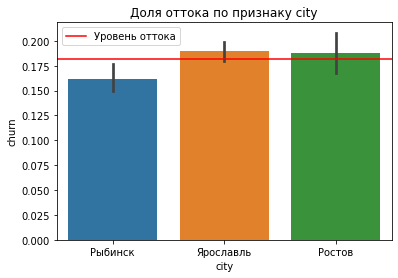

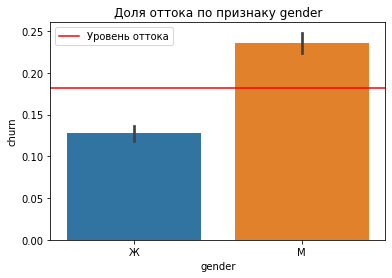

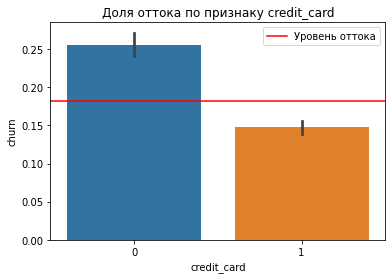

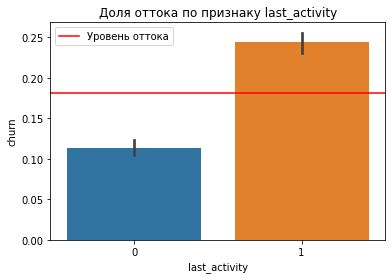

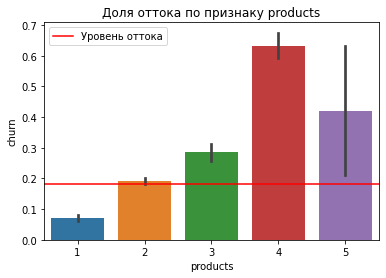

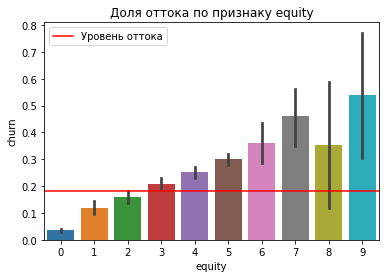

In [21]:
 for column in ['city', 'gender', 'credit_card', 'last_activity', 'products', 'equity']:
    ax = sns.barplot(data=df, x=column, y='churn')
    ax.axhline(y=df['churn'].mean(), color='red', label='Уровень оттока')
    plt.title(f'Доля оттока по признаку {column}')
    plt.legend()
    plt.show()

Наибольший отток клиентов отмечается у банка в Ярославле, а наименьший - в Рыбинске. Такой вывод не удивителен, ведь в Ярославле сконцентрировано большинство клиентов банка, а в Рыбинске - меньшинство и отток выглядит достаточно пропорциональным.

Мужчины более склонны к оттоку, чем женщины - примерно в 2 раза.

К оттоку более склонны клиенты, у которых нет кредитной карты банка.

Активные клиенты (которые заходили в приложение банка в последние 30 дней) чаще становятся отточными. Скорее всего это происходит из-за того что клиенты в приложении закрывают или блокируют ненужные им банковские продукты перед тем как уйти от банка. Вторая возможная причина - в неудобном приложении банка, в котором клиенты не могут разобраться, и , следовательно, уходят от банка.

Большинство клиентов банка пользуются 4 продуктами банка. Чуть реже - 5 продуктами. Отточные клиенты тоже чаще пользуются 2 продуктами. К оттоку склонны клиенты с 2 продуктами и более. Пик оттока у клиентов с 4 продуктами

У большинства клиентов баллы собственности находятся в диапазоне 6-9. По графику видно, что отток клиентов начинается а диапазоне от 3 баллов собственности и именно в диапазоне 6-9 баллов отток максимальный.

Text(0.5, 1.0, 'Распределение баллов кредитного скоринга')

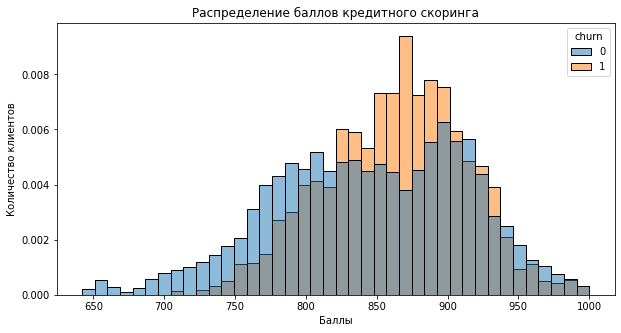

In [22]:
plt.figure(figsize=(10,5))

sns.histplot(data=df, x='score', hue='churn', stat='density', common_norm=False)

plt.xlabel('Баллы')
plt.ylabel('Количество клиентов')
plt.title('Распределение баллов кредитного скоринга')

Большинство клиентов банка имеют кредитный скоринг от 800 до 930 баллов. Именно в этом промежутке наибольший отток клиентов - приблизительно от 820 до 940 баллов. Наименьший отток клиентов у клиентов, имеющий кредитный скоринг от 650 до 800 баллов и от 950 до 1000.

(0.0, 3500000.0)

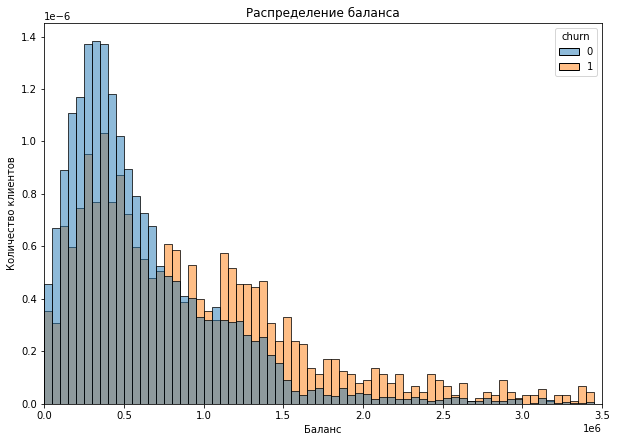

In [23]:
plt.figure(figsize=(10,7))

plot_balance = sns.histplot(data=df, x='balance', hue='churn', stat='density', common_norm=False, bins=range(0, 3500000, 50000))
plot_balance.set_title('Распределение баланса')
plot_balance.set_xlabel('Баланс')
plot_balance.set_ylabel('Количество клиентов')
plot_balance.set_xlim(0, 3500000)

В среднем на счете клиентов лежит 0-500 тыс. руб. Пик баланса приходится на 200-300 тыс. руб. на человека. Также наблюдаются редкие значения в несколько миллионов рублей. К оттоку склонны клиенты с балансом выше 750 тыс. руб.

(0.0, 600000.0)

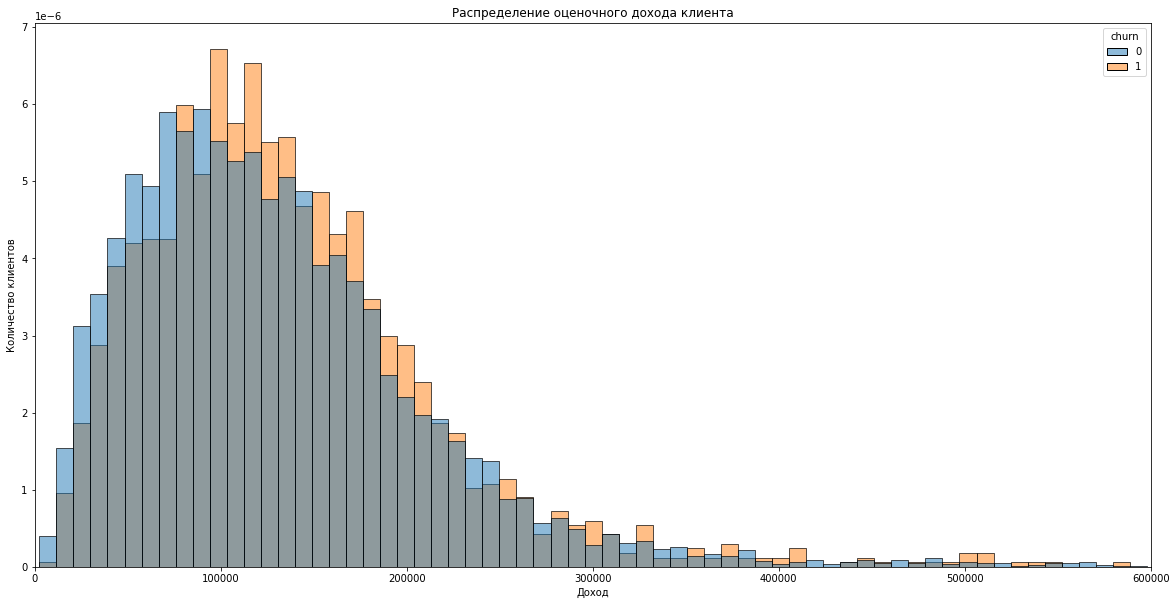

In [24]:
plt.figure(figsize=(20,10))

plot_salary = sns.histplot(data=df, x='est_salary', hue='churn', stat='density', common_norm=False)
plot_salary.set_title('Распределение оценочного дохода клиента')
plot_salary.set_xlabel('Доход')
plot_salary.set_ylabel('Количество клиентов')
plot_salary.set_xlim(0, 600000)

Оценочный доход клиента варьируется в основном в диапазоне 0-200 тыс. руб. в месяц. Но видны и очень редкие значения свыше 400 тыс. руб. Явный отток виден у клиентов с заработной платой от 90 тыс. руб.

Text(0, 0.5, 'Количество клиентов')

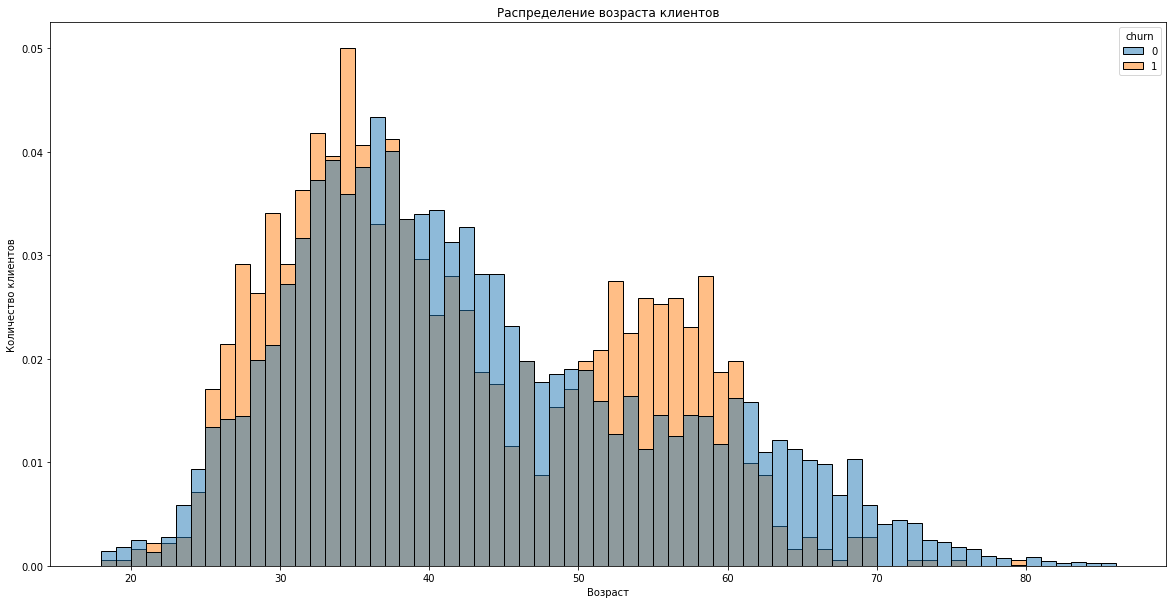

In [25]:
plt.figure(figsize=(20,10))

plot_age_1 = sns.histplot(data=df, x='age', hue='churn', stat='density', common_norm=False, binwidth = 1)
plot_age_1.set_title('Распределение возраста клиентов')
plot_age_1.set_xlabel('Возраст')
plot_age_1.set_ylabel('Количество клиентов')

Средний возраст клиента от 28 до 45 лет. Реже всего наблюдаются клиенты банка старше 77 лет. Клиентов младше 18 лет нет. Чаще всего от банка уходят клиенты в возрасте от 25 до 35 и от 50 до 60 лет.

**Вывод по пункту**

Наблюдается явное превышение оттока среди клиентов, попадающих в следующие категории:
1) Гендер: мужчины;

2) Кредитная карта: не имеется;

3) Баллы кредитного скоринга: от 820 до 940 баллов;

4) Баланс на счете: свыше 750 тыс. руб.;

5) Доход клиента: от 90 тыс. руб.;

6) Баллы собственности: 6-9;

7) Возраст: от 25 до 30 лет и от 50 до 60 лет;

8) Количество продуктов: 2-5.

### Корреляционный анализ и интерпретация

Text(0.5, 1.0, 'Корреляционная матрица Пирсона')

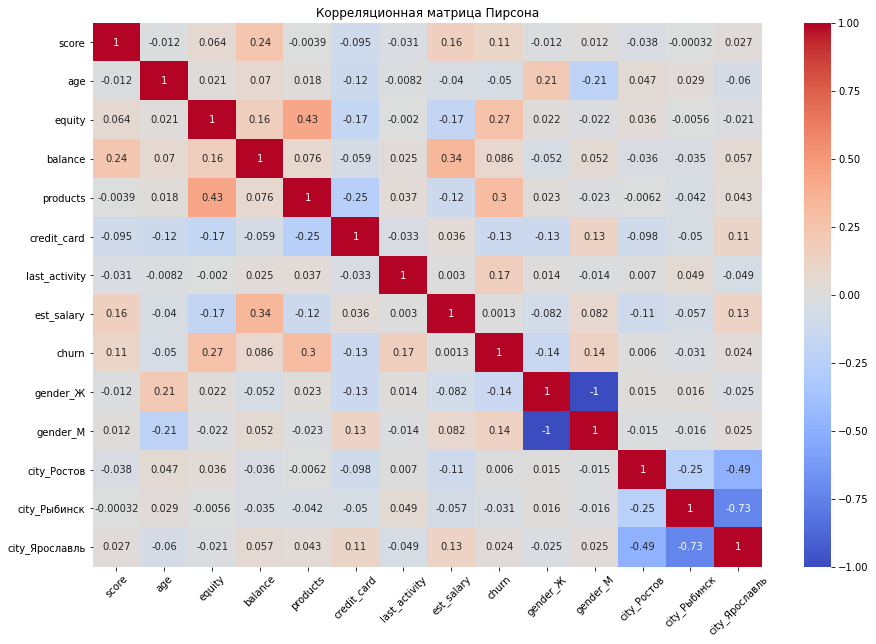

In [26]:
plt.figure(figsize=(15, 10))

sns.heatmap(df_coded.corr(), annot=True, cmap='coolwarm', center=0)
plt.xticks(rotation=45)
plt.title('Корреляционная матрица Пирсона')

Определим границу наличия и отсутствия признаков влияния в значение 10. 

Если влияние между признаками попадает под > ±10, то будем считать такой признак влияющем на отток клиентов. 

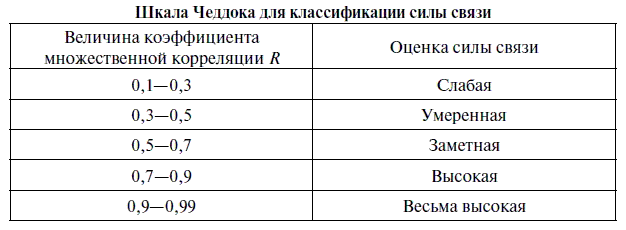

Анализируя матрицу Пирсона, видим, что сильной зависимости между признаками не наблюдается. Однако можно выделить следующие замечания, опираясь на шкалу Чеддока:

1) Слабое позитивное влияние (0.11) у оттока клиентов с кредитным скорингом. Чем выше баллы скоринга, тем они больше вляют на отточность клиентов;

2) Слабое позитивное влияние (0.27) у оттока клиентов с количеством баллов собственности. Чем больше баллов, тем они сильнее вляют на отточность клиентов;

3) Умеренное позитивное влияние (0.3) у оттока клиентов с количеством продуктов. Чем больше банковских продуктов у клиента, тем  сильнее они вляют на отточность;

4) Слабое отрицательное влияние (0.13) у оттока клиентов с наличием кредитной карты. Вероятность оттока клиента ниже, если у него есть кредитная карта;

5) Слабое позитивное влияние (0.17) у оттока клиентов с их активностью. Чем выше активность в приложении, тем сильнее вероятность оттока клиента;

6) Слабое отрицательное влияние (0.14) у оттока клиентов с женским гендером. Вероятность оттока клиента ниже, если он является женщиной;

7) Слабое позитивное влияние (0.14) у оттока клиентов с мужским гендером. Вероятность оттока клиента выше, если он является мужчиной.

Отталкиваясь то границы, можно сказать, что активность клиента, мужской гендер, количество продуктов, баллов собственности и баллов скоринга имеют влияние на отточность клиентов, по сравнению с другими признаками.

### Проверка статистических гипотез

Создадим 2 датасета: с оставшимися и отточными клиентами.

In [37]:
churn = df.query('churn == 1')
churn.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,59214.82,2,0,1,75719.14,1
3,225363,866.0,Ярославль,Ж,51.0,5,1524746.26,2,0,1,174423.53,1
4,157978,730.0,Ярославль,М,34.0,5,174.00,1,1,0,67353.16,1
12,132970,845.0,Ярославль,Ж,31.0,3,591928.52,2,1,1,112697.16,1
40,129705,811.0,Рыбинск,М,34.0,2,129799.35,1,0,0,96242.71,1


In [38]:
not_churn = df.query('churn == 0')
not_churn.head()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1,146556,861.0,Рыбинск,Ж,37.0,5,850594.33,3,1,0,86621.77,0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,107683.34,0
5,202305,856.0,Рыбинск,М,56.0,4,863687.24,3,1,0,156619.80,0
6,177259,807.0,Ярославль,Ж,39.0,3,405042.44,3,0,1,103838.32,0
7,218868,825.0,Ярославль,Ж,38.0,4,458145.40,2,1,1,68085.48,0


In [29]:
print(len(churn))
print(len(not_churn))

1820
8180


Проведем статистический t-тест для двух независимых выборок.

Обоснование инструмента:
1) Оба набора данных достаточно велики (n > 30);

2) Из первого пункта вытекает то, что данные в каждом наборе следуют нормальному распределению;

3) Дисперсии генеральных совокупностей наборов могут быть не равны, но мы зададим параметр equal_var=False.

Для проверки гипотез применим ttest_ind, т.к. он предназначен для проверки гипотезы о равенстве средних двух генеральных совокупностей.

**Гипотеза 1: Оценочный доход у отточных клиентов больше чем у оставшихся**

Сформулируем гипотезы:

- Н(0) - доход у отточных клиентов равен доходу оставшихся;
- Н(1) - доход у отточных клиентов больше.

In [30]:
print('среднее выборки churn:', np.mean(churn['est_salary']))
print('среднее выборки not_churn:', np.mean(not_churn['est_salary']))

alpha = 0.05
results = st.ttest_ind(churn['est_salary'],not_churn['est_salary'],alternative='greater',equal_var=False)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

среднее выборки churn: 148243.01019780218
среднее выборки not_churn: 147783.20010757947
p-значение: 0.4443527411061923
Не получилось отвергнуть нулевую гипотезу


Т.к. р-value оказалось больше уровня статистической значимости (alpha), то можно сделать вывод, что наблюдаемое значение достаточно близко к предполагаемому в нулевой гипотезе. Средние значения по доходу у отточных и оставшихся клиентов равны 148 тыс. руб. и 147 тыс. руб., соответственно. Доход у отточных клиентов равен доходу у оставшихся.

**Гипотеза 2: У отточных клиентов больше баллов кредитного скоринга чем у оставшихся**

Сформулируем гипотезы:

- Н(0) - количество баллов скоринга у отточных клиентов равно количеству баллов у оставшихся;
- Н(1) - количество баллов скоринга у отточных клиентов больше.

In [31]:
print('среднее выборки churn:', np.mean(churn['score']))
print('среднее выборки not_churn:', np.mean(not_churn['score']))

alpha = 0.05
results = st.ttest_ind(churn['score'],not_churn['score'],alternative='greater',equal_var=False)
print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

среднее выборки churn: 863.4010989010989
среднее выборки not_churn: 845.4283618581907
p-значение: 6.021543463828934e-38
Отвергаем нулевую гипотезу


Т.к. р-value оказалось меньше уровня статистической значимости (alpha), то можно сделать вывод, что наблюдаемое значение слишком далеко от предполагаемого в нулевой гипотезе. У отточных клиентов больше баллов кредитного скоринга чем у оставшихся на 18 единиц. Поэтому нулевая гипотеза отвергается в пользу альтернативной: количество баллов скоринга у отточных клиентов больше.

**Ввод по пункту**

В результате проверки гипотез мы выяснили, что:

1) Доход у отточных клиентов равен доходу у оставшихся;

2) Количество баллов скоринга у отточных клиентов больше.

### Подведение промежуточных итогов

*На этапе предобработки данных* мы переименовали два столбца для облегчения использвания их в дальнейшей работе. Анализируя пропущенные значения были выявлены пропуски только в столбцах age и balance. Они не зависят от переменных и не ведут к систематической ошибке, поэтому было принято решение оставить пропуски как есть. На шаге анализа дубликатов было выявлено 73 строки-дубликатов, но совпадений между парами дубликатов не было найдено. Далее, мы изменили значение-аномалию у клиента с количеством продуктов, равным нулю, на единицу. На конечном шаге мы провели one-hot кодирование переменных по столбцам gender и city.

*Наблюдается явное превышение оттока среди клиентов, попадающих в следующие категории:*

- Гендер: мужчины;
- Кредитная карта: не имеется;
- Баллы кредитного скоринга: от 820 до 940 баллов;
- Баланс на счете: свыше 750 тыс. руб.;
- Доход клиента: от 90 тыс. руб.;
- Баллы собственности: 6-9;
- Возраст: от 25 до 45 лет и от 50 до 60 лет;
- Количество продуктов: 2-5.

*Анализируя матрицу Пирсона, видим, что сильной зависимости между признаками не наблюдается. Однако можно выделить следующие замечания:*

1) Слабое позитивное влияние у оттока клиентов с:
- кредитным скорингом;
- количеством баллов собственности;
- наличием кредитной карты;
- активностью;
- с мужским гендером.

2) Умеренное позитивное влияние у оттока клиентов с:
- количеством продуктов.

3) Слабое отрицательное влияние у оттока клиентов 
- с женским гендером.


*В результате проверки гипотез мы выяснили, что:*

- Доход у отточных клиентов равен доходу у оставшихся;
- Количество баллов скоринга у отточных клиентов больше.

### Сегментация клиентов

Сегменты должны попадать под 2 условия:

1) в сегмент должны входить не менее 500 клиентов;

2) отток клиентов сегмента должен быть выше среднебанковского.

Определим среднебанковский отток:

In [32]:
len(churn)/len(df)*100

18.2

**1 Сегмент: Лояльные клиенты**

Признаки:
- заходили в приложение в последние 30 дней;
- пользуются 2 и более банковскими продуктами.

In [33]:
first_segment = df.query('products >= 2 and last_activity == 1')
print(f"Количество клиентов в сегменте:", len(first_segment))
print(f"Уровень оттока в сегменте: {len(churn.query('products >= 2 and last_activity == 1')) / len(first_segment) * 100:.2f}%")

Количество клиентов в сегменте: 3470
Уровень оттока в сегменте: 32.36%


**2 Сегмент: Молодые семьи**

Признаки:
- имеют кредитную карту;
- возраст от 25 до 30 лет.

In [34]:
second_segment = df.query('25 <= age <= 30 and credit_card == 1')
print(f"Количество клиентов в сегменте:", len(second_segment))
print(f"Уровень оттока в сегменте: {len(churn.query('25 <= age <= 30 and credit_card == 1')) / len(second_segment) * 100:.2f}%")

Количество клиентов в сегменте: 873
Уровень оттока в сегменте: 18.44%


**3 Сегмент: Состоятельные клиенты**

Признаки:
- доход свыше 200 тыс руб. в месяц;
- баланс на счете свыше 1 млн. руб.

In [35]:
third_segment = df.query('est_salary >= 200000 and balance >= 1000000')
print(f"Количество клиентов в сегменте:", len(third_segment))
print(f"Уровень оттока в сегменте: {len(churn.query('est_salary >= 200000 and balance >= 1000000')) / len(third_segment) * 100:.2f}%")

Количество клиентов в сегменте: 502
Уровень оттока в сегменте: 45.62%


### Приоритизация сегментов

Анализируя уровень оттока клиентов по вышеперечисленным сегментам, нам следует приоритизировать их в следующем порядке:

1) Сегмент 3 (Состоятельные клиенты);

2) Сегмент 1 (Лояльные клиенты);

3) Сегмент 2 (Молодые семьи).

Состоятельные клиенты имеют выше риск уйти от банка (45%), если они будут недовольны качеством обслуживания. Они не держатся за банк и легко могут завести несколько счетов в разных банках.

Лояльные клиенты имеют ниже риск перестать пользоваться продуктами банка (около 32%). Чем больше продуктов у лояльного клиента, тем выше вероятность, что один из продуктов перестанет его удовлетворять и клиент может покинуть банк в поисках более удобного продукта.

Молодые семьи наименее привержены к оттоку (17%). Причина в том, что имея маленьких детей и кредитные карты, семьи стараются выплачивать банку платежи и проценты в полном объеме, чтобы повысить баллы кредитного скоринга и быстрее расчитаться с долгами.

### Формирование рекомендаций по работе с сегментами

**Рекомендации для Сегмента 3 (Состоятельные клиенты)**

Удержание состоятельных клиентов особенно важно для банка (ведь чем больше денег лежит на картах и счетах у банка, тем ему выгоднее), стоит рассмотреть создание отдельной услуги наподобие Bank Private как у Сбера. В него будут входить: 
- личная помощь индивидуального менеджера по банковским услугам;
- индивидуальные ставки по депозитам и персональные условия по кредитам;
- доступ к личным сейфовым ячейкам и покупка драгоценных металлов;
- праймовый пакет услуг с эксклюзивными сервисами и преимуществами.

**Рекомендации для Сегмента 1 (Лояльные клиенты)**

Лояльные клиенты - клиенты, которые пользуются большим количеством продуктов банка и часто заходят в мобильное приложение. Чем больше продуктов у такого клиента, тем выше вероятность его недовольства одним из продуктов или работы приложения. Для сохранения таких клиентов сейчас и в будущем банку стоит провести процесс оптимизации продуктов и самого мобильного приложения. Для этого стоит предпринять следующие шаги:

- проанализировать техническим специалистам внутренную работу приложения;
- собрать с клиентов обратную связь об их удовлетворенности работой продуктов и приложения;
- исправить ошибки и доработать недочеты;
- регулярно повторять эти действия для предотвращения преждевременного оттока клиентов.

**Рекомендации для Сегмента 2 (Молодые семьи)**

Молодым семьям, использующим кредитные карты, очень важна помощь банка в выплачивании ипотеки или кредитов. Банку также стоит рассмотреть открытие отдельной услуги, направленной на поддержку клиентов, впервые столкнувшимися с кредитными продуктами. В эту услугу могут входить:

- финансовые консультации менеджеров, ответственных за кредитование;
- возможность планирования выплат по кредитам на удобных для клиента условиях;
- создание специальной программы для тех семей, которые собираются погашать ипотеки и кредиты досрочно, с возможностью снижения процента или накопление бонусов.

Рекомендуется создание отдельных специальных сервисов, ориентированных на интересы клиентов: Bank Private для состоятельных клиентов и программу поддержки молодых семей. Также для всех остальных клиентов банку рекомендуется постоянно проводить оптимизацию своих продуктов и анализ банковского приложения.

## Общий вывод

На этапе **предобработки данных** мы совершили следующие шаги:

- переименовали столбцы user_id и est_salary;
- выявили пропуски в столбцах age и balance, не зависящие от переменных. Поэтому было принято решение не заполнять и не удалять их;
- выявили 73 строки-дубликатов без совпадений между парами дубликатов;
- изменили значение-аномалию у клиента с количеством продуктов, равным нулю, на единицу;
- провели one-hot кодирование переменных по столбцам gender и city.

Во время **исследовательского анализа** мы наблюдали явное превышение оттока среди клиентов, попадающих в следующие категории:

- Гендер: мужчины;
- Кредитная карта: не имеется;
- Баллы кредитного скоринга: от 820 до 940 баллов;
- Баланс на счете: свыше 750 тыс. руб.;
- Доход клиента: от 90 тыс. руб.;
- Баллы собственности: 6-9;
- Возраст: от 25 до 45 лет и от 50 до 60 лет.

**Корреляционный анализ** показал, что активность клиента, мужской гендер, количество продуктов, баллов собственности и баллов скоринга имеют влияние на отточность клиентов, по сравнению с другими признаками. Ранее мы определили границу наличия признаков влияния в >10.

Перед **проверкой статистических гипотез** мы создали 2 датасета: с отточными клиентами и оставшимися. 

Первую гипотезу о равенстве дохода отточных клиентов и оставшихся не получилось отвергнуть. Средние значения по доходу у отточных и оставшихся клиентов равны 148 тыс. руб. и 147 тыс. руб., соответственно.

Вторая гипотеза о равенстве количества баллов скоринга отточных клиентов и оставшихся была отвергнута. У отточных клиентов больше баллов кредитного скоринга чем у оставшихся на 18 единиц.

На этапе **сегментации клиентов** мы создали 3 сегмента: 

- Сегмент 1 (Лояльные клиенты) (уровень оттока в сегменте: 32.36%);
- Сегмент 2 (Молодые семьи) (уровень оттока в сегменте: 17.11%);
- Сегмент 3 (Состоятельные клиенты) (уровень оттока в сегменте: 45.62%).

Анализируя полученные уровня оттока сегментов, было решено **приоритизировать созданные сегменты** в следующем порядке:

- Сегмент 3 (Состоятельные клиенты);
- Сегмент 1 (Лояльные клиенты);
- Сегмент 2 (Молодые семьи).

Конечным шагом проекта было **формирование рекомендаций по работе с сегментами**.

Для Сегмента 3 (Состоятельные клиенты) рекомендовано создание отдельной услуги наподобие Bank Private, куда будут входить:
- личная помощь индивидуального менеджера по банковским услугам;
- индивидуальные ставки по депозитам и персональные условия по кредитам;
- доступ к личным сейфовым ячейкам и покупка драгоценных металлов;
- праймовый пакет услуг с эксклюзивными сервисами и преимуществами.

Для Сегмента 2 (Лояльные клиенты) рекомендовано проводить процессы оптимизации продуктов и самого мобильного приложения. Для этого стоит предпринять следующие шаги:
- проанализировать техническим специалистам внутренную работу приложения;
- собрать с клиентов обратную связь об их удовлетворенности работой продуктов и приложения;
- исправить ошибки и доработать недочеты;
- регулярно повторять эти действия для предотвращения преждевременного оттока клиентов.

Для Сегмента 1 (Молодые семьи) рекомендовано открытие отдельной услуги, направленной на поддержку клиентов, впервые столкнувшимися с кредитными продуктами. В эту услугу могут входить:

- финансовые консультации менеджеров, ответственных за кредитование;
- возможность планирования выплат по кредитам на удобных для клиента условиях;
- создание специальной программы для тех семей, которые собираются погашать ипотеки и кредиты досрочно, с возможностью снижения - процента или накопление бонусов.